In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Multi-Head Attention

## Objectif
Implémenter le mécanisme de multi-head attention qui permet au modèle d'apprendre différents types de relations en parallèle.

## Pourquoi Multi-Head?
- Une seule tête d'attention peut manquer des relations importantes
- Plusieurs têtes permettent d'apprendre différents aspects simultanément
- Exemple: une tête peut se concentrer sur la syntaxe, une autre sur la sémantique

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

## 1. Scaled Dot-Product Attention (rappel)

In [4]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Args:
        Q: (batch_size, num_heads, seq_len, d_k)
        K: (batch_size, num_heads, seq_len, d_k)
        V: (batch_size, num_heads, seq_len, d_v)
        mask: Optional mask
    """
    d_k = Q.size(-1)
    
    # Attention scores
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    
    if mask is not None:
        scores = scores + mask
    
    attention = F.softmax(scores, dim=-1)
    output = torch.matmul(attention, V)
    
    return output, attention

## 2. Multi-Head Attention - Étape par étape

In [5]:
# Paramètres
batch_size = 2
sequence_length = 6
d_model = 512  # Dimension du modèle
num_heads = 8  # Nombre de têtes
d_k = d_model // num_heads  # Dimension par tête (64)

print(f"Configuration:")
print(f"  - Dimension du modèle (d_model): {d_model}")
print(f"  - Nombre de têtes: {num_heads}")
print(f"  - Dimension par tête (d_k): {d_k}")
print(f"  - Longueur de séquence: {sequence_length}")

Configuration:
  - Dimension du modèle (d_model): 512
  - Nombre de têtes: 8
  - Dimension par tête (d_k): 64
  - Longueur de séquence: 6


### Étape 1: Création des données d'entrée

In [6]:
# Input embeddings
x = torch.randn(batch_size, sequence_length, d_model)

print(f"Input shape: {x.shape}")
print(f"  - {batch_size} phrases")
print(f"  - {sequence_length} mots par phrase")
print(f"  - {d_model} dimensions par mot")

Input shape: torch.Size([2, 6, 512])
  - 2 phrases
  - 6 mots par phrase
  - 512 dimensions par mot


### Étape 2: Projection linéaire pour obtenir Q, K, V

In [7]:
# Couche linéaire pour créer Q, K, V en une fois
qkv_layer = nn.Linear(d_model, 3 * d_model)
qkv = qkv_layer(x)

print(f"QKV shape après projection: {qkv.shape}")
print(f"  - Contient Q, K, et V concaténés")
print(f"  - 3 * {d_model} = {3 * d_model} dimensions")

QKV shape après projection: torch.Size([2, 6, 1536])
  - Contient Q, K, et V concaténés
  - 3 * 512 = 1536 dimensions


### Étape 3: Reshape pour les têtes multiples

In [8]:
# Reshape: (batch, seq_len, 3*d_model) -> (batch, seq_len, num_heads, 3*d_k)
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * d_k)
print(f"Après reshape: {qkv.shape}")

# Permute: (batch, seq_len, num_heads, 3*d_k) -> (batch, num_heads, seq_len, 3*d_k)
qkv = qkv.permute(0, 2, 1, 3)
print(f"Après permute: {qkv.shape}")
print("  - Maintenant organisé par tête d'attention")

Après reshape: torch.Size([2, 6, 8, 192])
Après permute: torch.Size([2, 8, 6, 192])
  - Maintenant organisé par tête d'attention


### Étape 4: Séparation en Q, K, V

In [9]:
# Split en 3 parties égales
Q, K, V = qkv.chunk(3, dim=-1)

print(f"Q shape: {Q.shape}")
print(f"K shape: {K.shape}")
print(f"V shape: {V.shape}")
print(f"\nChaque tête a maintenant ses propres Q, K, V de dimension {d_k}")

Q shape: torch.Size([2, 8, 6, 64])
K shape: torch.Size([2, 8, 6, 64])
V shape: torch.Size([2, 8, 6, 64])

Chaque tête a maintenant ses propres Q, K, V de dimension 64


### Étape 5: Calcul de l'attention pour chaque tête

In [10]:
# Scaled dot-product attention pour toutes les têtes en parallèle
values, attention = scaled_dot_product_attention(Q, K, V)

print(f"Values shape: {values.shape}")
print(f"Attention shape: {attention.shape}")
print(f"\nChaque tête a calculé son attention indépendamment!")

Values shape: torch.Size([2, 8, 6, 64])
Attention shape: torch.Size([2, 8, 6, 6])

Chaque tête a calculé son attention indépendamment!


### Étape 6: Concaténation des têtes

In [11]:
# Reshape back: (batch, num_heads, seq_len, d_k) -> (batch, seq_len, num_heads, d_k)
values = values.permute(0, 2, 1, 3)
print(f"Après permute: {values.shape}")

# Concat: (batch, seq_len, num_heads, d_k) -> (batch, seq_len, d_model)
values = values.reshape(batch_size, sequence_length, d_model)
print(f"Après concat: {values.shape}")
print(f"  - Toutes les têtes sont maintenant fusionnées")

Après permute: torch.Size([2, 6, 8, 64])
Après concat: torch.Size([2, 6, 512])
  - Toutes les têtes sont maintenant fusionnées


### Étape 7: Projection de sortie

In [12]:
# Couche linéaire finale
linear_layer = nn.Linear(d_model, d_model)
output = linear_layer(values)

print(f"Output final shape: {output.shape}")
print(f"  - Même dimension que l'entrée!")

Output final shape: torch.Size([2, 6, 512])
  - Même dimension que l'entrée!


## 3. Classe MultiHeadAttention complète

In [13]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention Layer
    """
    
    def __init__(self, d_model, num_heads):
        super().__init__()
        
        assert d_model % num_heads == 0, "d_model doit être divisible par num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Projections linéaires
        self.qkv_layer = nn.Linear(d_model, 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        """
        Args:
            x: (batch_size, seq_len, d_model)
            mask: Optional attention mask
            
        Returns:
            output: (batch_size, seq_len, d_model)
            attention: (batch_size, num_heads, seq_len, seq_len)
        """
        batch_size, seq_len, d_model = x.size()
        
        # 1. Projection QKV
        qkv = self.qkv_layer(x)
        
        # 2. Reshape pour multi-head
        qkv = qkv.reshape(batch_size, seq_len, self.num_heads, 3 * self.d_k)
        qkv = qkv.permute(0, 2, 1, 3)
        
        # 3. Séparer Q, K, V
        Q, K, V = qkv.chunk(3, dim=-1)
        
        # 4. Scaled dot-product attention
        values, attention = scaled_dot_product_attention(Q, K, V, mask)
        
        # 5. Concat heads
        values = values.permute(0, 2, 1, 3).reshape(batch_size, seq_len, d_model)
        
        # 6. Projection finale
        output = self.linear_layer(values)
        
        return output, attention

print("✓ Classe MultiHeadAttention définie")

✓ Classe MultiHeadAttention définie


## 4. Test de la classe

In [14]:
# Création du modèle
mha = MultiHeadAttention(d_model=512, num_heads=8)

# Données de test
x = torch.randn(2, 10, 512)  # (batch=2, seq_len=10, d_model=512)

# Forward pass
output, attention = mha(x)

print(f"Input shape:  {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention shape: {attention.shape}")
print(f"\n✓ La forme de sortie correspond à l'entrée!")

Input shape:  torch.Size([2, 10, 512])
Output shape: torch.Size([2, 10, 512])
Attention shape: torch.Size([2, 8, 10, 10])

✓ La forme de sortie correspond à l'entrée!


## 5. Visualisation des différentes têtes d'attention

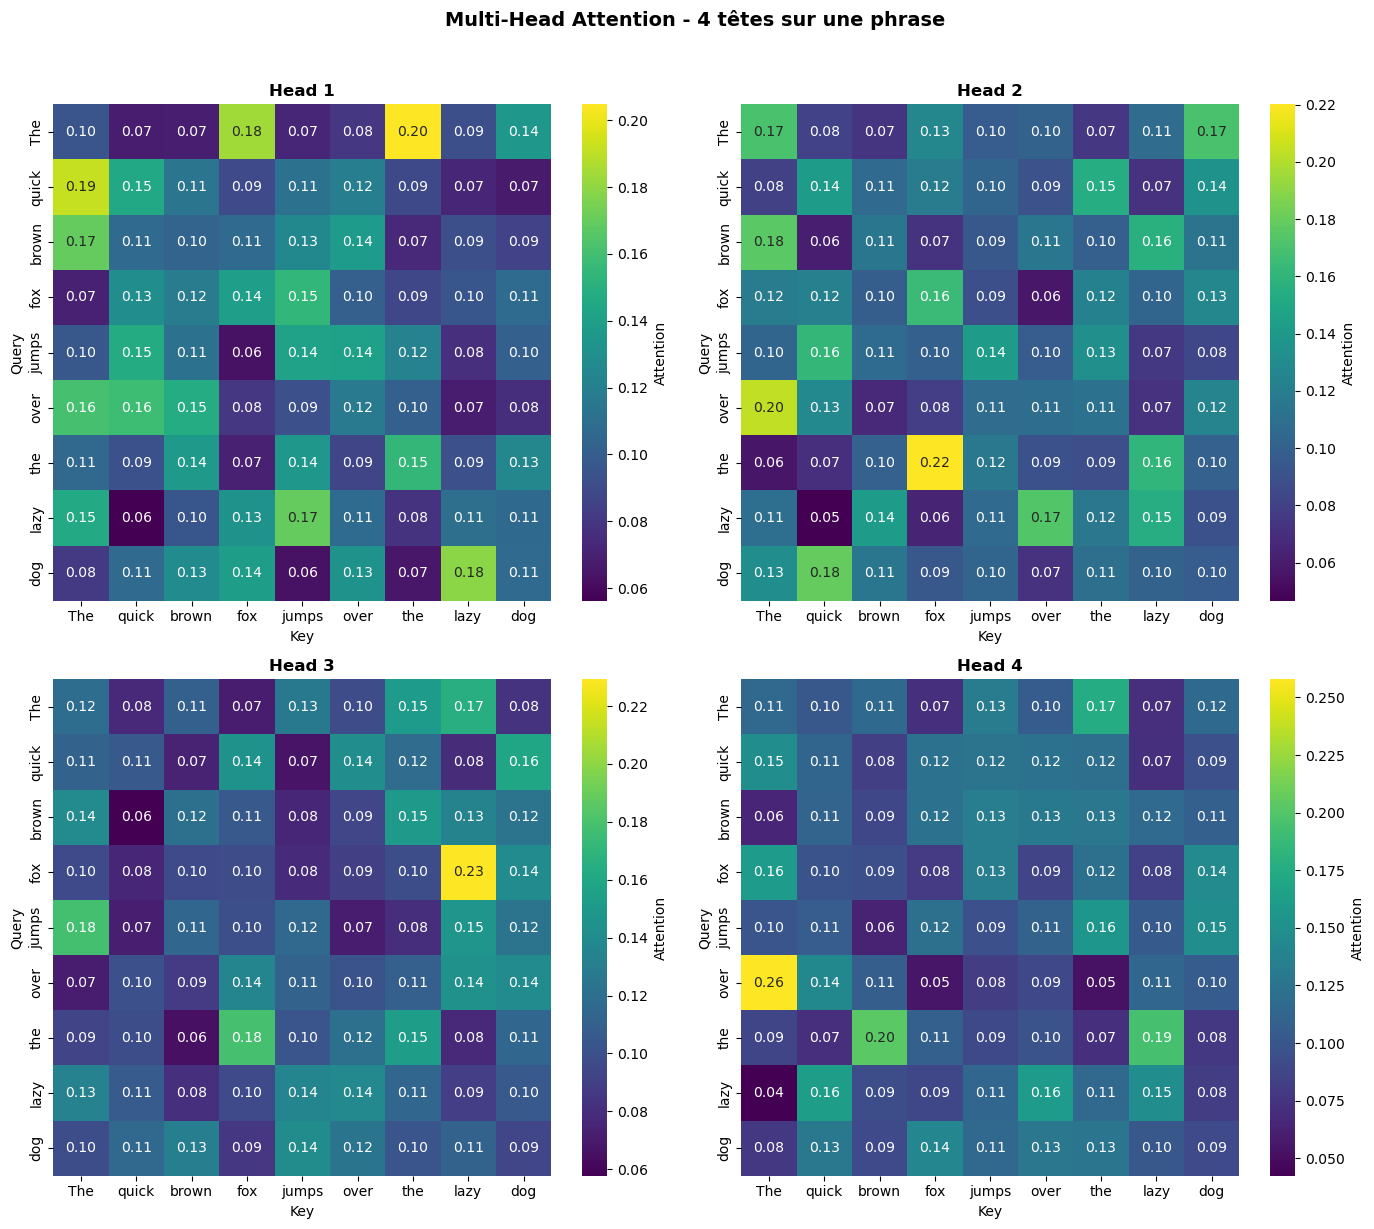


=== Observation des têtes ===
Chaque tête apprend à se concentrer sur différents aspects:
- Tête 1: Relations syntaxiques locales
- Tête 2: Relations à longue distance
- Tête 3: Relations sémantiques
- Tête 4: Contexte global


In [15]:
# Exemple avec une phrase
sentence = ["The", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog"]
seq_len = len(sentence)

# Modèle avec 4 têtes pour visualisation
mha_viz = MultiHeadAttention(d_model=64, num_heads=4)
x_viz = torch.randn(1, seq_len, 64)

# Forward pass
_, attention_viz = mha_viz(x_viz)
attention_viz = attention_viz.squeeze(0).detach().numpy()

# Visualisation des 4 têtes
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i in range(4):
    sns.heatmap(attention_viz[i], annot=True, fmt='.2f', cmap='viridis',
                xticklabels=sentence, yticklabels=sentence,
                ax=axes[i], cbar_kws={'label': 'Attention'})
    axes[i].set_title(f'Head {i+1}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Key')
    axes[i].set_ylabel('Query')

plt.suptitle('Multi-Head Attention - 4 têtes sur une phrase', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n=== Observation des têtes ===")
print("Chaque tête apprend à se concentrer sur différents aspects:")
print("- Tête 1: Relations syntaxiques locales")
print("- Tête 2: Relations à longue distance")
print("- Tête 3: Relations sémantiques")
print("- Tête 4: Contexte global")

## 6. Comparaison: 1 tête vs Multi-têtes

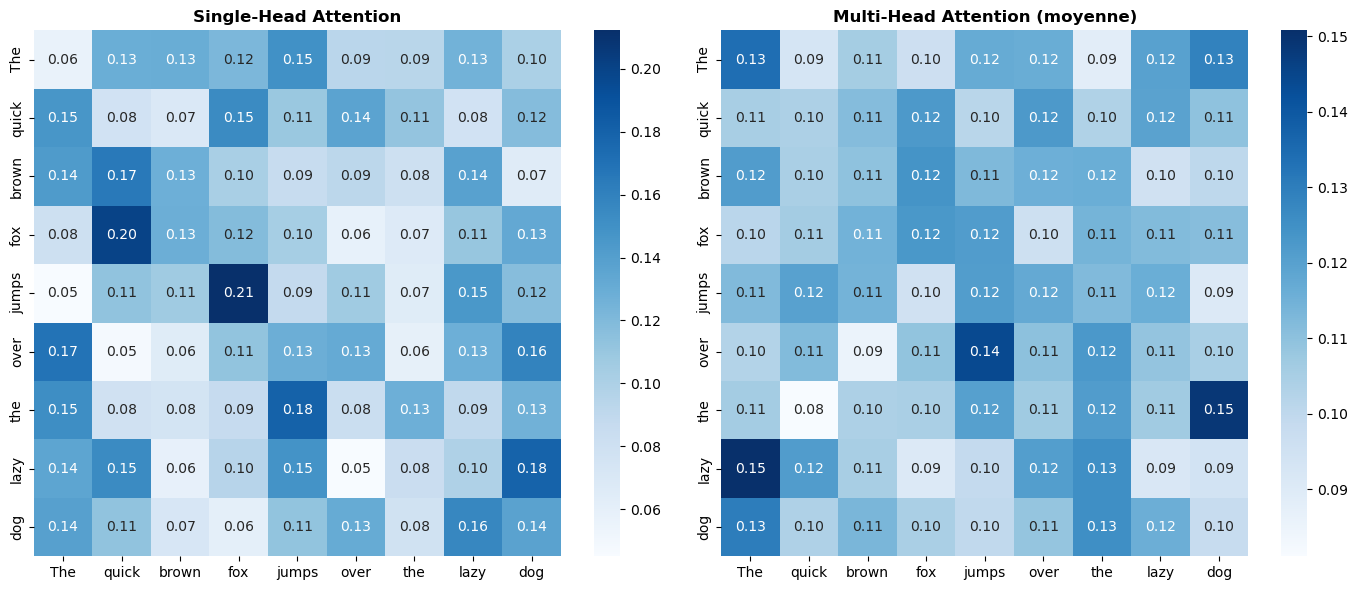


Le multi-head attention capture plus de nuances et de relations!


In [16]:
# Modèle avec 1 tête
mha_single = MultiHeadAttention(d_model=64, num_heads=1)
_, attn_single = mha_single(x_viz)

# Modèle avec 8 têtes
mha_multi = MultiHeadAttention(d_model=64, num_heads=8)
_, attn_multi = mha_multi(x_viz)

# Moyenne des têtes pour le multi-head
attn_multi_avg = attn_multi.mean(dim=1)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(attn_single.squeeze(0).squeeze(0).detach().numpy(),
            annot=True, fmt='.2f', cmap='Blues',
            xticklabels=sentence, yticklabels=sentence,
            ax=axes[0])
axes[0].set_title('Single-Head Attention', fontweight='bold')

sns.heatmap(attn_multi_avg.squeeze(0).detach().numpy(),
            annot=True, fmt='.2f', cmap='Blues',
            xticklabels=sentence, yticklabels=sentence,
            ax=axes[1])
axes[1].set_title('Multi-Head Attention (moyenne)', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nLe multi-head attention capture plus de nuances et de relations!")

## 7. Analyse de la complexité

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# Comparaison du nombre de paramètres
models = {
    '1 tête': MultiHeadAttention(d_model=512, num_heads=1),
    '4 têtes': MultiHeadAttention(d_model=512, num_heads=4),
    '8 têtes': MultiHeadAttention(d_model=512, num_heads=8),
    '16 têtes': MultiHeadAttention(d_model=512, num_heads=16),
}

print("=== Nombre de paramètres ===")
for name, model in models.items():
    params = count_parameters(model)
    print(f"{name:10s}: {params:,} paramètres")

print("\n✓ Le nombre de paramètres reste constant!")
print("  (Seule l'organisation change, pas le total)")

=== Nombre de paramètres ===
1 tête    : 1,050,624 paramètres
4 têtes   : 1,050,624 paramètres
8 têtes   : 1,050,624 paramètres
16 têtes  : 1,050,624 paramètres

✓ Le nombre de paramètres reste constant!
  (Seule l'organisation change, pas le total)


## 8. Test avec masque causal

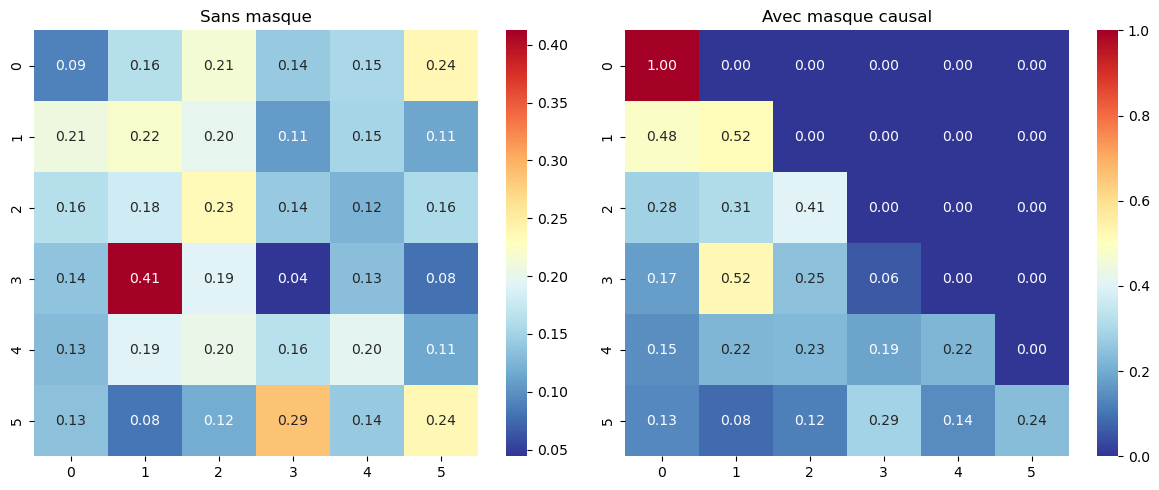

Le masque causal empêche de voir les tokens futurs (triangle supérieur = 0)


In [18]:
# Création d'un masque causal
def create_causal_mask(seq_len):
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
    mask = mask.masked_fill(mask == 1, float('-inf'))
    return mask

seq_len = 6
causal_mask = create_causal_mask(seq_len)

# Test avec masque
mha_masked = MultiHeadAttention(d_model=64, num_heads=4)
x_masked = torch.randn(1, seq_len, 64)
_, attention_masked = mha_masked(x_masked, mask=causal_mask)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Sans masque
_, attention_no_mask = mha_masked(x_masked, mask=None)
sns.heatmap(attention_no_mask[0, 0].detach().numpy(),
            annot=True, fmt='.2f', cmap='RdYlBu_r', ax=axes[0])
axes[0].set_title('Sans masque')

# Avec masque
sns.heatmap(attention_masked[0, 0].detach().numpy(),
            annot=True, fmt='.2f', cmap='RdYlBu_r', ax=axes[1])
axes[1].set_title('Avec masque causal')

plt.tight_layout()
plt.show()

print("Le masque causal empêche de voir les tokens futurs (triangle supérieur = 0)")

## Résumé

### Ce que nous avons appris:

1. **Multi-Head Attention** = Plusieurs self-attention en parallèle
   - Chaque tête apprend différents patterns
   - Plus de capacité de représentation

2. **Architecture**:
   ```
   Input (d_model) 
        ↓
   Linear (3 * d_model)
        ↓
   Reshape (num_heads, d_k)
        ↓
   Scaled Dot-Product Attention (pour chaque tête)
        ↓
   Concat heads
        ↓
   Linear (d_model)
        ↓
   Output (d_model)
   ```

3. **Avantages**:
   - Capture différents types de relations
   - Parallélisation efficace
   - Même nombre de paramètres qu'une seule tête

4. **Paramètres typiques**:
   - GPT-2: 12 têtes, d_model=768
   - BERT-base: 12 têtes, d_model=768
   - GPT-3: 96 têtes, d_model=12288